# Introduction to Machine Learning and Deep Learning

### Acknowledgements

The content of this notebook was originally created by Nils Eckstein, Julia Buhmann, and Jan Funke for the 2021 DL@MBL course in Woods Hole, and later chopped up and modified by Florian Jug and Igor Zubarev for the 2022 course DL4MIA.

Some code cells will be marked with

########################################################################### <br>
#######                     FIND WAYS TO IMPROVE                    ####### <br>
########################################################################### <br>

or 

########################################################################### <br>
#######                      START OF YOUR CODE                     ####### <br>
########################################################################### <br>

... <br>

########################################################################### <br>
#######                       END OF YOUR CODE                      ####### <br>
########################################################################### <br>

This indicates that you need to find a possible errors in the code or in the function parameters. Or add some code...

### Let's get the MNIST data...

This is one of the most famous and most frequently used datasets of small images of hand-written digits and their corresponding ground-truth classes.

In this exercise we will learn to predict the correct class given an image of a hand-written digit.

In [1]:
from torchvision import datasets as dts
import torchvision
transforms = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
trainset=dts.MNIST(root='./data',train=True,download=True,
                   transform=transforms)


print('Train data ', len(trainset))

/Users/ashesh.ashesh/miniconda3/envs/Disentangle/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train data  60000
Test data  10000


In [3]:
inp, tar = trainset[0]

In [4]:
inp.shape

torch.Size([1, 28, 28])

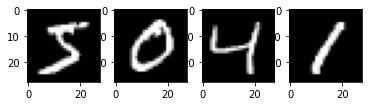

In [5]:
# This cell should also be run for the super bonus exercise 
import numpy as np
import matplotlib.pyplot as plt


# Show example data
plt.subplot(1,4,1)
plt.imshow(trainset[0][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,2)
plt.imshow(trainset[1][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,3)
plt.imshow(trainset[2][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,4)
plt.imshow(trainset[3][0][0], cmap=plt.get_cmap('gray'))
plt.show()

### Brind data in the shape we need during training...

In particular, this cell performs the following:
 * add a channel dimension to train and test data
 * normalize the pixel intensities to [0,1]
 * transform the ground-truth label from a digit (0, ..., 9) to one-hot encoded vectors. (Example: the one-hot encoded vector for digit `3` will become `0001000000`, etc.)

### Let's create a network we'd like to train...

The one currently implemented in the cell below will turn out to not work so well. Run it anyways, but then come back here and start playing with changing the network architecture and hopefully find a better working model for the task at hand!

### Show a few more examples, so we also see some of the errors...

In [6]:
# fig, axes = plt.subplots(5, 8, figsize=(20,15))
# errors=0
# for i in range(40):
#     if y_predict_digits[i]==y_test[i]:
#         axes.flatten()[i].imshow(x_test[i,:,:,0], cmap=plt.get_cmap('gray'))
#         axes.flatten()[i].set_title('ok')
#     else:
#         axes.flatten()[i].imshow(x_test[i,:,:,0], cmap=plt.get_cmap('Reds'))
#         axes.flatten()[i].set_title('PREDICTION: %s'%(y_predict_digits[i]))
#         errors+=1
        
# print("Errors: %d"%errors)

In [7]:
# Test if GPU is available in torch. We may need to run this part on CPU because of hardware incompability
import torch 
print('CUDA available: ', torch.cuda.is_available())
print('PyTorch version: ', torch.__version__)

# Assign correct device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

CUDA available:  False
PyTorch version:  1.13.1


In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
# from torchsummary import summary


# Define hyperparameters
epochs = 3
batch_size = 64
learning_rate = 1e-3

# Let's convert numpy arrays to torch tensors and create a Dataset object. 
# Note, that we don't need to convert to one-hot, but we need to change the order of dimensions 
# to comply with torch convention [batch_size, channels, H, W]
# tensor.permute is applied on a tensor and inputs new order of dimesions

# Create a dataset object
train_dataset = trainset 

# Define an iterable dataloader which allows batching
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

# Define a loss function 
loss_func = nn.CrossEntropyLoss()


# Now let's define a model. PyTorch models and layers inherit from torch.nn.Module
class MNIST_Classifier(nn.Module):
    def __init__(self):
        super(MNIST_Classifier, self).__init__()
        
        # Hint: You need to correct the number of channels in convolutional layers as you did with TensoFlow model above
        # Note that you need to set input and output channels separately. 
        # You can also look at the output shapes in the torchsummary
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        
        # Hint: Note that you need to set input and output channels separately and consecutive layers 
        # should have the same number of filters
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        self.fc1 = nn.Linear(in_features=800, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=10)
    
    def forward(self, x):
        
        # Layers are essentially functions. So here we sequantially apply those to the input. 
        # You can also use print(x.size()) after any step for debug
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # View operation reshapes tensor with -1 meaning all the remaining values will go to that dimension
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Create model instance and move it to GPU
model = MNIST_Classifier()
model.to(device)

# Finally let's define an optimizer. Note that we need to provide parameters, 
# which will be optimized(in our case, all model parameters) and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Visualize the model. PyTorch doesn't have an in-built model summary. 
# It's available via a separate torchsummary package. We provide the model itself and the shape of the input tensor
# summary(model, (1, 28, 28))

### Define a training loop and train the network...


In [9]:
# Iterate over number of epochs
for epoch in range(epochs):
    train_loss_results = 0
    train_accuracy_results = 0
    
    # Set model to train/eval mode is important for some layers(e.g. Dropout) to behave correctly
    model.train()
    print(f'\n----- epoch {epoch} -----')
    
    # Iterate over the dataloader. Each iteration produces one batch of shape [batch_size, channels, H, W]
    for data in train_dataloader:
        inputs, labels = data
        
        # Move images and labels to correct device. This operation is only required for gpu training
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Set the gradients of all tensors to zero 
        optimizer.zero_grad()
        
        # Compute forward pass(calling forward method of a model) for current batch
        predictions = model(inputs)
        
        # Calculate the loss value 
        loss = loss_func(predictions, labels.long())
        
        # Compute the gradient of the loss function w.r.t every model parameter, that has requires_grad=True
        loss.backward()
        
        # Update the parameters using the gradients
        optimizer.step()
        
        # Accumulate loss values. We only store the number by calling .item()
        train_loss_results += loss.item()
        
        # Accumulate accuracy by first taking the index of largest logit, 
        # comparing it with the ground truth labels and summing accross batch
        train_accuracy_results += ((predictions.argmax(dim=1) == labels).sum().item())

    print(f'Loss: {train_loss_results / len(train_dataloader)}')
    print(f'Accuracy: {100 * train_accuracy_results / (batch_size * len(train_dataloader))}')
                


----- epoch 0 -----
Loss: 0.30947034655343386
Accuracy: 90.69163113006397

----- epoch 1 -----
Loss: 0.09760098474006901
Accuracy: 96.89332356076758

----- epoch 2 -----
Loss: 0.07369708971367148
Accuracy: 97.57462686567165


## Evaluation.

In [ ]:
# Lets create a test dataset and dataloader
test_dataset =dts.MNIST(root='./data',train=False,download=True,
                   transform=transforms)

print('Test data ', len(test_dataset))


### Let's see how well we did qualitatively...

In [ ]:
# Show example data
def get_prediction(inp):
    inp = inp.to(device)
    pred_tmp = model(inp.unsqueeze(0))
    pred_tmp = pred_tmp.argmax(dim=1).item()
    return pred_tmp

plt.subplot(1,4,1)
inp_tmp, tar_tmp = test_dataset[0]
pred_tmp = get_prediction(inp_tmp)
ax = plt.imshow(inp_tmp[0], cmap=plt.get_cmap('gray'))
plt.gca().set_title(f'Pred:{pred_tmp}, GT:{tar_tmp}')

plt.subplot(1,4,2)
inp_tmp, tar_tmp = test_dataset[4]
pred_tmp = get_prediction(inp_tmp)
ax = plt.imshow(inp_tmp[0], cmap=plt.get_cmap('gray'))
plt.gca().set_title(f'Pred:{pred_tmp}, GT:{tar_tmp}')

plt.subplot(1,4,3)
inp_tmp, tar_tmp = test_dataset[12]
pred_tmp = get_prediction(inp_tmp)
ax = plt.imshow(inp_tmp[0], cmap=plt.get_cmap('gray'))
plt.gca().set_title(f'Pred:{pred_tmp}, GT:{tar_tmp}')

plt.subplot(1,4,4)
inp_tmp, tar_tmp = test_dataset[21]
pred_tmp = get_prediction(inp_tmp)
ax = plt.imshow(inp_tmp[0], cmap=plt.get_cmap('gray'))
plt.gca().set_title(f'Pred:{pred_tmp}, GT:{tar_tmp}')
plt.show()

### Bonus exercise! Implement validation loop in PyTorch

Usually, validation is done inside the training loop

***Hint:*** Almost all the steps are analogous to the training loop, and there's no gradient calculation! 

In [10]:
###########################################################################
#######                   START OF YOUR CODE                        #######
###########################################################################


# Define an iterable dataloader which allows batching
# Hint: Look for how train_dataloader was created above.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size) #...

test_loss_results = 0
test_accuracy_results = 0 
    
# This context manager is needed to disable gradient calculation for  
with torch.no_grad():
    for test_data in test_dataloader: #...
        test_inputs, test_labels = test_data
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)

        # Compute forward pass
        test_predictions = model(test_inputs)#....

        # Calculate loss value
        test_loss = loss_func(test_predictions, test_labels.long())#....

        test_loss_results += test_loss.item() #....
        test_accuracy_results += ((test_predictions.argmax(dim=1) == test_labels).sum().item()) #....

    print(f'Loss: {test_loss_results / len(test_dataloader)}')
    print(f'Accuracy: {100 * test_accuracy_results / (batch_size * len(test_dataloader))}')
        

###########################################################################
#######                    END OF YOUR CODE                         #######
###########################################################################

Test data  10000
Loss: 0.07993623416516396
Accuracy: 96.89490445859873


### Once you're done, please answer these question:

 * What did you play with, what made the biggest difference?
 * How many parameters did you end up unsing?
 * How long did you train the network?
 * What was the best test-error you got overall?

### Congratulations! You've made it to the end 